# BraTS-2020 — 3D U-Net Segmentation (MONAI + TorchIO)

**Author:** Ismail Berriss / Soufiane Jadda  
**Date:** 2025-11-26  
**Purpose:** End-to-end 3D brain tumor segmentation pipeline using the BraTS-2020 dataset and a 3D U-Net model.

---

## Notebook Overview

This notebook implements a complete workflow for multi-modal brain tumor segmentation:

1. **Setup & Verification** — Install dependencies, detect GPU, set seeds
2. **Data Loading & Preprocessing** — Load BraTS NIfTI volumes, normalize, resample, crop
3. **Model Architecture** — 3D U-Net with configurable channels and depth
4. **Training Pipeline** — Patch-based training with augmentations, loss tracking, validation
5. **Evaluation & Metrics** — Dice score, Hausdorff95, per-region metrics (WT, TC, ET)
6. **Inference & Post-processing** — Sliding-window prediction, connected-component filtering
7. **Uncertainty Estimation** — Monte Carlo Dropout for voxel-wise uncertainty
8. **Visualization & Export** — Result overlays, uncertainty heatmaps, artifact export

**Estimated runtime:** ~30-60 minutes for a single epoch on a 24GB GPU (full BraTS-2020 training set). Use the "Quick Debug" mode to test the pipeline in ~5-10 minutes.

---

## Section 0: Installation & Environment Setup

In [ ]:
# Install dependencies
# This cell installs all required packages for the notebook.
# If running in Colab, uncomment the pip commands. For local installs, use conda.

import subprocess
import sys

packages_to_install = [
    'torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118',
    'monai[all]',
    'torchio',
    'nibabel',
    'numpy pandas scipy scikit-learn matplotlib seaborn',
    'tqdm',
    'pytest',  # for validation
]

print("Installing dependencies... This may take a few minutes.")
for package in packages_to_install:
    print(f"\n>>> Installing: {package}")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q'] + package.split())

print("\n✓ Installation complete!")

In [1]:
# Import core libraries and print versions

import os
import sys
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchio as tio
import nibabel as nib
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.transforms import Compose, EnsureChannelFirst, NormalizeIntensity, Spacing
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from scipy import ndimage
from sklearn.model_selection import KFold
from pathlib import Path
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime

# Version printing
print("="*70)
print(f"Environment Information | {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)
print(f"Python version:           {sys.version.split()[0]}")
print(f"PyTorch version:          {torch.__version__}")
print(f"NumPy version:            {np.__version__}")
print(f"Nibabel version:          {nib.__version__}")
print(f"TorchIO version:          {tio.__version__}")
print(f"MONAI version:            {__import__('monai').__version__}")
print(f"Pandas version:           {pd.__version__}")
print("="*70)

# GPU Detection
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"\n✓ CUDA is available!")
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    device = torch.device('cpu')
    print(f"\n⚠ CUDA not available. Using CPU. Training will be very slow.")

print(f"\nDevice selected: {device}")
print("="*70)

Environment Information | 2025-11-29 21:11:48
Python version:           3.13.5
PyTorch version:          2.9.0+cu130
NumPy version:            2.1.3
Nibabel version:          5.3.2
TorchIO version:          0.21.0
MONAI version:            1.5.1
Pandas version:           2.2.3

✓ CUDA is available!
  GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
  VRAM: 4.3 GB

Device selected: cuda


In [2]:
# Set random seeds for reproducibility

SEED = 42

# NumPy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Deterministic behavior (may reduce performance)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"✓ Random seeds set to {SEED} for reproducibility.")
print("  Note: deterministic mode may reduce training speed.")

✓ Random seeds set to 42 for reproducibility.
  Note: deterministic mode may reduce training speed.


---

## Section 1: Configuration & Dataset Setup

In [3]:
# Global configuration and hyperparameters

class Config:
    """Central configuration for the entire pipeline."""
    
    # === Dataset Paths ===
    # Set DATA_ROOT to your local BraTS-2020 directory structure:
    #   dataset/
    #   └── MICCAI_BraTS2020_TrainingData/
    #       ├── BraTS20_Training_001/
    #       │   ├── BraTS20_Training_001_flair.nii
    #       │   ├── BraTS20_Training_001_seg.nii
    #       │   ├── BraTS20_Training_001_t1.nii
    #       │   ├── BraTS20_Training_001_t1ce.nii
    #       │   ├── BraTS20_Training_001_t2.nii
    #       ├── BraTS20_Training_002/
    #       └── ...
    DATA_ROOT = './dataset/MICCAI_BraTS2020_TrainingData'
    OUTPUT_DIR = './output'
    CHECKPOINT_DIR = './checkpoint'
    
    # === Quick Debug Mode ===
    # Set to True to use only 2 subjects and 1 epoch for testing
    DEBUG_MODE = True  # Change to True for quick testing
    
    # === Training Hyperparameters ===
    PATCH_SIZE = (128, 128, 128)  # Patch size for patch-based training
    BATCH_SIZE = 1  # Batch size (reduce if OOM: 1 or 2)
    NUM_EPOCHS = 50  # Number of training epochs
    LEARNING_RATE = 1e-3  # Initial learning rate
    WEIGHT_DECAY = 1e-5  # L2 regularization
    NUM_WORKERS = 0  # DataLoader workers
    
    # === Model Configuration ===
    IN_CHANNELS = 4  # T1, T1ce, T2, FLAIR
    OUT_CHANNELS = 4  # Background, NCR/NET, ED, ET
    INITIAL_FEATURES = 32  # Starting feature maps for U-Net
    
    # === Data Configuration ===
    TARGET_SPACING = (1.0, 1.0, 1.0)  # Isotropic 1mm
    MODALITIES = ['t1', 't1ce', 't2', 'flair']  # Modality order
    
    # === Class Labels (BraTS) ===
    # 0 = Background, 1 = NCR/NET, 2 = ED, 4 = ET (merged to 3)
    CLASS_NAMES = ['Background', 'NCR/NET', 'ED', 'ET']
    
    # === Inference ===
    INFERENCE_PATCH_SIZE = (128, 128, 128)
    INFERENCE_OVERLAP = 0.5  # Overlap ratio for sliding window
    MC_DROPOUT_PASSES = 20  # Passes for Monte Carlo Dropout uncertainty
    
    # === Validation ===
    VALIDATION_SPLIT = 0.2  # 80% train, 20% val
    
    @staticmethod
    def print_config():
        """Print all configuration parameters."""
        print("\n" + "="*70)
        print("CONFIGURATION SUMMARY")
        print("="*70)
        for key, value in Config.__dict__.items():
            if not key.startswith('_') and not callable(value):
                print(f"{key:.<40} {value}")
        print("="*70 + "\n")

# Print config
Config.print_config()


CONFIGURATION SUMMARY
DATA_ROOT............................... ./dataset/MICCAI_BraTS2020_TrainingData
OUTPUT_DIR.............................. ./output
CHECKPOINT_DIR.......................... ./checkpoint
DEBUG_MODE.............................. True
PATCH_SIZE.............................. (128, 128, 128)
BATCH_SIZE.............................. 1
NUM_EPOCHS.............................. 50
LEARNING_RATE........................... 0.001
WEIGHT_DECAY............................ 1e-05
NUM_WORKERS............................. 0
IN_CHANNELS............................. 4
OUT_CHANNELS............................ 4
INITIAL_FEATURES........................ 32
TARGET_SPACING.......................... (1.0, 1.0, 1.0)
MODALITIES.............................. ['t1', 't1ce', 't2', 'flair']
CLASS_NAMES............................. ['Background', 'NCR/NET', 'ED', 'ET']
INFERENCE_PATCH_SIZE.................... (128, 128, 128)
INFERENCE_OVERLAP....................... 0.5
MC_DROPOUT_PASSES.........

In [4]:
# Create necessary directories

os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)

print(f"✓ Output directory: {Config.OUTPUT_DIR}")
print(f"✓ Checkpoint directory: {Config.CHECKPOINT_DIR}")

✓ Output directory: ./output
✓ Checkpoint directory: ./checkpoint


In [5]:
# Verify BraTS-2020 dataset structure

def verify_dataset_structure(data_root):
    """
    Verify that the BraTS-2020 dataset is properly structured.
    Raises an error if the dataset is not found or malformed.
    """
    data_root = Path(data_root)
    
    if not data_root.exists():
        raise FileNotFoundError(
            f"Dataset directory not found: {data_root}\n\n"
            "Please update Config.DATA_ROOT to point to your BraTS2020 folder.\n\n"
            "Expected structure:\n"
            "  dataset/\n"
            "  └──MICCAI_BraTS2020_TrainingData/\n"
            "       ├── BraTS20_Training_001/\n"
            "       │   ├── BraTS20_Training_001_flair.nii\n"
            "       │   ├── BraTS20_Training_001_seg.nii\n"
            "       │   ├── BraTS20_Training_001_t1.nii\n"
            "       │   ├── BraTS20_Training_001_t1ce.nii\n"
            "       │   ├── BraTS20_Training_001_t2.nii\n"
            "       ├── BraTS20_Training_002/\n"
            "       └── ..."
        )
    
    subject_folders = [f for f in data_root.iterdir() if f.is_dir() and f.name.startswith('BraTS20_Training')]

    
    if len(subject_folders) == 0:
        raise FileNotFoundError(
            f"No BraTS20_Training_* folders found in {data_root}\n"
            "Please check your DATA_ROOT path."
        )
    
    # Verify first subject has all required files
    test_subject = subject_folders[0]
    required_files = ['t1.nii', 't1ce.nii', 't2.nii', 'flair.nii', 'seg.nii']
    
    for mod in required_files:
        expected_file = test_subject / f"{test_subject.name}_{mod}"
        if not expected_file.exists():
            raise FileNotFoundError(
                f"Missing file: {expected_file}\n"
                "Each subject folder should contain: t1, t1ce, t2, flair, and seg .nii files"
            )
    
    print("\n" + "="*70)
    print("DATASET VERIFICATION")
    print("="*70)
    print(f"Data root: {data_root}")
    print(f"Total subjects found: {len(subject_folders)}")
    
    # Show sample subjects
    print(f"\nSample subjects (first 5):")
    for subject_folder in sorted(subject_folders)[:5]:
        print(f"  - {subject_folder.name}")
    
    print("="*70 + "\n")
    
    return subject_folders

# Run verification
try:
    subject_folders = verify_dataset_structure(Config.DATA_ROOT)
    print(f"✓ Dataset verified: {len(subject_folders)} subjects ready for training")
except FileNotFoundError as e:
    print(f"\n❌ ERROR: {e}")
    print("\nPlease update Config.DATA_ROOT in the cell above.")


DATASET VERIFICATION
Data root: dataset\MICCAI_BraTS2020_TrainingData
Total subjects found: 369

Sample subjects (first 5):
  - BraTS20_Training_001
  - BraTS20_Training_002
  - BraTS20_Training_003
  - BraTS20_Training_004
  - BraTS20_Training_005

✓ Dataset verified: 369 subjects ready for training


---

## Section 2: Data Preprocessing & Utilities

In [6]:
# BraTS Label Mapping and Utilities

class BraTSLabels:
    """
    BraTS label definitions and mappings.
    Original BraTS labels: 0=background, 1=NCR/NET, 2=ED, 4=ET
    We remap to: 0=background, 1=NCR/NET, 2=ED, 3=ET
    """
    BACKGROUND = 0
    NCR_NET = 1      # Necrotic and Non-Enhancing Tumor
    ED = 2           # Peritumoral Edema
    ET = 3           # Enhancing Tumor (remapped from 4 to 3)
    
    # Region definitions for evaluation metrics
    # Whole Tumor (WT): NCR/NET + ED + ET = labels {1, 2, 3}
    # Tumor Core (TC): NCR/NET + ET = labels {1, 3}
    # Enhancing Tumor (ET): ET only = label {3}
    
    @staticmethod
    def get_region_mask(segmentation, region='WT'):
        """
        Extract a specific region from multi-class segmentation.
        
        Args:
            segmentation: (H, W, D) array with class labels
            region: 'WT' (Whole Tumor), 'TC' (Tumor Core), or 'ET' (Enhancing Tumor)
        
        Returns:
            Binary mask for the region
        """
        if region == 'WT':  # Whole Tumor
            return np.isin(segmentation, [1, 2, 3]).astype(np.uint8)
        elif region == 'TC':  # Tumor Core
            return np.isin(segmentation, [1, 3]).astype(np.uint8)
        elif region == 'ET':  # Enhancing Tumor
            return (segmentation == 3).astype(np.uint8)
        else:
            raise ValueError(f"Unknown region: {region}")

print("✓ BraTS label utilities loaded")

✓ BraTS label utilities loaded


In [7]:
# Data Loading and Preprocessing Functions

def load_subject_volumes(data_root, subject_folder_name):
    """
    Load all modalities (T1, T1ce, T2, FLAIR) and segmentation label for a subject.
    
    Args:
        data_root: Path to MICCAI_BraTS2020_TrainingData folder
        subject_folder_name: Subject folder name (e.g., 'BraTS20_Training_001')
    
    Returns:
        Dictionary with 'volumes' (4, H, W, D) and 'label' (H, W, D)
    """
    data_root = Path(data_root)
    subject_folder = data_root / subject_folder_name
    
    if not subject_folder.exists():
        raise FileNotFoundError(f"Subject folder not found: {subject_folder}")
    
    modalities = ['t1', 't1ce', 't2', 'flair']
    volumes = []
    
    for mod in modalities:
        file_path = subject_folder / f"{subject_folder_name}_{mod}.nii"
        if not file_path.exists():
            raise FileNotFoundError(f"Missing: {file_path}")
        
        img = nib.load(file_path)
        data = img.get_fdata().astype(np.float32)
        volumes.append(data)
    
    # Stack modalities: (4, H, W, D)
    volumes_array = np.stack(volumes, axis=0)
    
    # Load segmentation label
    label_path = subject_folder / f"{subject_folder_name}_seg.nii"
    label_img = nib.load(label_path)
    label_data = label_img.get_fdata().astype(np.uint8)
    
    # Remap label 4 (ET) to 3 for consistency
    label_data[label_data == 4] = 3
    
    return {
        'volumes': volumes_array,
        'label': label_data,
        'affine': img.affine,
        'header': img.header
    }


def normalize_modality(volume, mask=None, use_nonzero_mask=True):
    """
    Z-score normalize a single modality.
    Can optionally use a brain mask to exclude background voxels.
    
    Args:
        volume: (H, W, D) array
        mask: Optional (H, W, D) binary mask for normalization region
        use_nonzero_mask: If True and mask is None, use nonzero voxels
    
    Returns:
        Normalized volume
    """
    if use_nonzero_mask and mask is None:
        mask = volume > 0
    
    if mask is not None:
        masked_volume = volume[mask]
        if len(masked_volume) > 0:
            mean = masked_volume.mean()
            std = masked_volume.std()
            if std > 0:
                volume = (volume - mean) / std
    else:
        mean = volume.mean()
        std = volume.std()
        if std > 0:
            volume = (volume - mean) / std
    
    return volume


def preprocess_subject(subject_data, target_spacing=(1.0, 1.0, 1.0)):
    """
    Preprocess a subject: normalize modalities, resample to isotropic spacing.
    
    Args:
        subject_data: Dict with 'volumes', 'label', 'affine'
        target_spacing: Target voxel spacing in mm
    
    Returns:
        Preprocessed subject data
    """
    volumes = subject_data['volumes'].copy()  # (4, H, W, D)
    label = subject_data['label'].copy()       # (H, W, D)
    
    # Normalize each modality independently
    brain_mask = volumes[0] > 0  # Use T1 as reference for brain mask
    for i in range(volumes.shape[0]):
        volumes[i] = normalize_modality(volumes[i], mask=brain_mask)
    
    # Optional: Resample to isotropic 1mm (can be expensive, skip for now)
    # For speed, we'll just normalize and crop
    
    return {
        'volumes': volumes,
        'label': label,
        'affine': subject_data['affine']
    }

print("✓ Preprocessing utilities loaded")

✓ Preprocessing utilities loaded


In [39]:
# Custom Dataset for patch-based training

class BraTSDataset(Dataset):
    """
    PyTorch Dataset for BraTS 3D volumes with patch-based sampling.
    Loads subjects on demand and extracts random patches during training.
    """
    
    def __init__(
        self,
        data_root,
        subject_folder_names,
        patch_size=(128, 128, 128),
        augment=False,
        num_patches_per_subject=1,
        cache_size=0,
    ):
        self.data_root = Path(data_root)
        self.subject_ids = list(subject_folder_names)
        self.subject_folder_names = subject_folder_names
        self.patch_size = patch_size
        self.augment = augment
        self.num_patches_per_subject = num_patches_per_subject
        self.cache_size = cache_size
        
        # # Preload and cache all subject data
        # self.subject_data_cache = {}
        # self._load_all_subjects()
        
        # If caching is enabled, wrap load_subject in LRU cache
        if cache_size > 0:
            from functools import lru_cache
            self._load_subject_cached = lru_cache(maxsize=cache_size)(self._load_subject_uncached)
        else:
            self._load_subject_cached = self._load_subject_uncached
    
    def _load_subject_uncached(self, subject_id):
        """Load and preprocess a single subject — NOT cached by default."""
        raw_data = load_subject_volumes(self.data_root, subject_id)
        return preprocess_subject(raw_data)
    
    # def _load_all_subjects(self):
    #     """Load and preprocess all subjects into memory."""
    #     print(f"Loading {len(self.subject_ids)} subjects...")
    #     for subject_id in tqdm(self.subject_ids, desc="Loading subjects"):
    #         try:
    #             raw_data = load_subject_volumes(
    #                 self.image_dir, self.label_dir, subject_id
    #             )
    #             processed = preprocess_subject(raw_data)
    #             self.subject_data_cache[subject_id] = processed
    #         except Exception as e:
    #             print(f"Warning: Failed to load {subject_id}: {e}")
    
    def _extract_random_patch(self, volumes, label, idx=0):
        """
        Extract a random patch from a volume.
        If the volume is smaller than patch_size, pad it.
        """
        _, h, w, d = volumes.shape
        ph, pw, pd = self.patch_size
        
        # Ensure volume is at least patch_size
        pad_h = max(0, ph - h)
        pad_w = max(0, pw - w)
        pad_d = max(0, pd - d)
        if pad_h or pad_w or pad_d:
            volumes = np.pad(
                volumes,
                ((0, 0), (0, pad_h), (0, pad_w), (0, pad_d)),
                mode='constant'
            )
            label = np.pad(
                label,
                ((0, pad_h), (0, pad_w), (0, pad_d)),
                mode='constant'
            )
            _, h, w, d = volumes.shape
        
        _, h, w, d = volumes.shape
        
        # Random patch location
        np.random.seed(42 + idx)
        torch.manual_seed(42 + idx)
        
        h_start = np.random.randint(0, h - ph + 1) if h > ph else 0
        w_start = np.random.randint(0, w - pw + 1) if w > pw else 0
        d_start = np.random.randint(0, d - pd + 1) if d > pd else 0
        
        print(f"h_start: {h_start}")
        print(f"h_start: {w_start}")
        print(f"h_start: {d_start}")
        
        patch_volumes = volumes[
            :, h_start:h_start+ph, w_start:w_start+pw, d_start:d_start+pd
        ]
        patch_label = label[
            h_start:h_start+ph, w_start:w_start+pw, d_start:d_start+pd
        ]
        
        return patch_volumes, patch_label
    
    def _apply_augmentations(self, volumes, label):
        """
        Apply data augmentations:
        - Random flip (left-right)
        - Random rotation (small angles)
        - Random gamma adjustment
        """
        # Random flip along H axis (left-right)
        if np.random.rand() > 0.5:
            volumes = np.flip(volumes, axis=1).copy()
            label = np.flip(label, axis=0).copy()
        
        # Random gamma adjustment (intensity correction)
        if np.random.rand() > 0.5:
            gamma = np.random.uniform(0.7, 1.3)
            volumes = np.power(np.maximum(volumes, 0), gamma)
        
        # Random small rotation (via TorchIO would be better, but for speed we keep it simple)
        if np.random.rand() > 0.7:
            # Small rotation around Z axis
            from scipy import ndimage
            angle = np.random.uniform(-15, 15)
            for i in range(volumes.shape[0]):
                volumes[i] = ndimage.rotate(
                    volumes[i], angle, axes=(0, 1), order=1, reshape=False
                )
            label = ndimage.rotate(
                label, angle, axes=(0, 1), order=0, reshape=False
            )
        
        return volumes, label
    
    def __len__(self):
        return len(self.subject_ids) * self.num_patches_per_subject
    
    def __getitem__(self, idx):
        subject_idx = idx // self.num_patches_per_subject
        patch_idx = idx % self.num_patches_per_subject  # unused, but keeps indexing clear
        subject_id = self.subject_ids[subject_idx]
        
        try:
            subject_data = self._load_subject_cached(subject_id)
        except Exception as e:
            raise RuntimeError(f"Failed to load subject '{subject_id}': {e}") from e  
        
        volumes = subject_data['volumes'].copy()
        label = subject_data['label'].copy()
        
        # Extract random patch
        patch_volumes, patch_label = self._extract_random_patch(volumes, label, idx=subject_idx)
        
        # Apply augmentations if training
        if self.augment:
            patch_volumes, patch_label = self._apply_augmentations(
                patch_volumes, patch_label
            )
        
        # Convert to tensors
        volumes_tensor = torch.from_numpy(patch_volumes).float()
        label_tensor = torch.from_numpy(patch_label).long()
        
        return {
            'image': volumes_tensor,
            'label': label_tensor,
            'subject_id': subject_id
        }

print("✓ BraTSDataset class loaded")

✓ BraTSDataset class loaded


---

## Section 3: Model Architecture (3D U-Net)

In [40]:
# Build 3D U-Net Model

def build_unet_model(
    in_channels=4,
    out_channels=4,
    initial_features=32,
    dropout_rate=0.1
):
    """
    Build a 3D U-Net model using MONAI.
    
    Args:
        in_channels: Number of input channels (4 for BraTS)
        out_channels: Number of output classes (4 for BraTS)
        initial_features: Number of features in first conv layer
        dropout_rate: Dropout rate for Monte Carlo uncertainty
    
    Returns:
        UNet model
    """
    model = UNet(
        spatial_dims=3,
        in_channels=in_channels,
        out_channels=out_channels,
        channels=(32, 64, 128, 256),
        strides=(2, 2, 2),
        num_res_units=2,
        dropout=dropout_rate,  # Needed for MC Dropout
    )
    
    return model


# Instantiate model
model = build_unet_model(
    in_channels=Config.IN_CHANNELS,
    out_channels=Config.OUT_CHANNELS,
    initial_features=Config.INITIAL_FEATURES,
    dropout_rate=0.1
)

model = model.to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


print("\n" + "="*70)
print("MODEL ARCHITECTURE")
print("="*70)
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print("\nModel Architecture:")
print(model)
print("="*70 + "\n")


MODEL ARCHITECTURE
Total Parameters: 4,748,837
Trainable Parameters: 4,748,837

Model Architecture:
UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.1, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.1, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
  

---

## Section 4: Loss Function & Metrics

In [41]:
# Loss Function and Optimizer Setup

# Combined loss: Dice + CrossEntropy
loss_function = DiceCELoss(
    include_background=False,  # Ignore background class
    to_onehot_y=True,
    softmax=True,
    weight=None,
    reduction='mean'
)

# Optimizer: AdamW with learning rate scheduling
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=Config.LEARNING_RATE,
    weight_decay=Config.WEIGHT_DECAY
)

# Learning rate scheduler: CosineAnnealingLR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=Config.NUM_EPOCHS,
    eta_min=1e-6
)

print("✓ Loss function: DiceCELoss")
print("✓ Optimizer: AdamW")
print(f"  Learning Rate: {Config.LEARNING_RATE}")
print(f"  Weight Decay: {Config.WEIGHT_DECAY}")
print("✓ Scheduler: CosineAnnealingLR")

✓ Loss function: DiceCELoss
✓ Optimizer: AdamW
  Learning Rate: 0.001
  Weight Decay: 1e-05
✓ Scheduler: CosineAnnealingLR


In [42]:
# Evaluation Metrics

def compute_dice_score(pred_mask, target_mask):
    """
    Compute Dice score for a specific class.
    
    Args:
        pred: (H, W, D) predicted class
        target: (H, W, D) ground truth class
    
    Returns:
        Dice score (float)
    """
    intersection = np.sum(pred_mask * target_mask)
    denominator = np.sum(pred_mask) + np.sum(target_mask)
    
    if denominator == 0:
        # return 1.0 if np.sum(target_mask) == 0 else 0.0
        return 1.0 if np.p.array_equal(pred_mask, target_mask) == 0 else 0.0
    
    return 2.0 * intersection / denominator


def compute_hausdorff95(pred_mask, target_mask, spacing=(1, 1, 1)):
    """
    Compute 95th percentile Hausdorff distance.
    
    Args:
        pred: Predicted mask
        target: Ground truth mask
        spacing: Voxel spacing
    
    Returns:
        HD95 distance
    """
    # pred_mask = (pred == label_idx).astype(np.uint8)
    # target_mask = (target == label_idx).astype(np.uint8)
    
    if pred_mask.sum() == 0 or target_mask.sum() == 0:
        return 0.0 if np.array_equal(pred_mask, target_mask) else 373.13  # Max distance
    
    try:
        from scipy.spatial.distance import directed_hausdorff
        
        # Get boundary voxels
        pred_surface = ndimage.binary_erosion(pred_mask) != pred_mask
        target_surface = ndimage.binary_erosion(target_mask) != target_mask
        
        pred_coords = np.array(np.where(pred_surface)).T * spacing
        target_coords = np.array(np.where(target_surface)).T * spacing
        
        if len(pred_coords) == 0 or len(target_coords) == 0:
            return 0.0
        
        d1 = directed_hausdorff(pred_coords, target_coords)[0]
        d2 = directed_hausdorff(target_coords, pred_coords)[0]
        return max(d1, d2)
    except:
        return 0.0


def evaluate_brats_metrics(pred, target):
    """
    Compute BraTS evaluation metrics for all regions.
    
    Args:
        pred: Predicted segmentation (H, W, D)
        target: Ground truth segmentation (H, W, D)
    
    Returns:
        Dictionary with Dice scores for WT, TC, ET
    """
    regions = {
        'WT': (BraTSLabels.get_region_mask(target, 'WT'),
                BraTSLabels.get_region_mask(pred, 'WT')),
        'TC': (BraTSLabels.get_region_mask(target, 'TC'),
                BraTSLabels.get_region_mask(pred, 'TC')),
        'ET': (BraTSLabels.get_region_mask(target, 'ET'),
                BraTSLabels.get_region_mask(pred, 'ET')),
    }
    
    metrics = {}
    for region, (target_mask, pred_mask) in regions.items():
        # --- Dice ---
        metrics[f'Dice_{region}'] = compute_dice_score(pred_mask, target_mask)
        # --- 95th percentile Hausdorff distance ---
        metrics[f"HD95_{region}"] = compute_hausdorff95(pred_mask, target_mask)
    
    return metrics

print("✓ Metric functions loaded")

✓ Metric functions loaded


---

## Section 5: Training Pipeline

⚠️ **Warning: Full training may take 30-60+ minutes on a 24GB GPU.**  
To test the pipeline quickly, enable `DEBUG_MODE` in the Config cell above.

In [43]:
# Prepare Data: List subjects and split into train/val

data_root = Path(Config.DATA_ROOT)

# Extract subject IDs from image files
all_subject_folders = sorted([
    f.name for f in data_root.iterdir() 
    if f.is_dir() and f.name.startswith('BraTS20_Training')
])

if Config.DEBUG_MODE:
    all_subject_folders = all_subject_folders[:2]  # Only 2 subjects for debugging
    print(f"DEBUG MODE: Using only {len(all_subject_folders)} subjects")

# Train/val split
n_val = max(1, int(len(all_subject_folders) * Config.VALIDATION_SPLIT))
train_subjects = all_subject_folders[:-n_val]
val_subjects = all_subject_folders[-n_val:]

print(f"\n✓ Dataset Split:")
print(f"  Total subjects: {len(all_subject_folders)}")
print(f"  Training: {len(train_subjects)}")
print(f"  Validation: {len(val_subjects)}")
print(f"\n  Training subjects: {train_subjects[:3]}...")
print(f"  Validation subjects: {val_subjects}")

DEBUG MODE: Using only 2 subjects

✓ Dataset Split:
  Total subjects: 2
  Training: 1
  Validation: 1

  Training subjects: ['BraTS20_Training_001']...
  Validation subjects: ['BraTS20_Training_002']


In [44]:
# Create DataLoaders

batch_size = 1 if Config.DEBUG_MODE else Config.BATCH_SIZE
num_epochs = 1 if Config.DEBUG_MODE else Config.NUM_EPOCHS

print(f"Creating training dataset (patch size: {Config.PATCH_SIZE})...")
train_dataset = BraTSDataset(
    data_root=data_root,
    subject_folder_names=train_subjects,
    patch_size=Config.PATCH_SIZE,
    augment=False,
    num_patches_per_subject=2  # 2 random patches per subject per epoch
)

print(f"Creating validation dataset...")
val_dataset = BraTSDataset(
    data_root=data_root,
    subject_folder_names=val_subjects,
    patch_size=Config.PATCH_SIZE,
    augment=False,
    num_patches_per_subject=1
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"\n✓ DataLoaders created:")
print(f"  Train batches per epoch: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")

Creating training dataset (patch size: (128, 128, 128))...
Creating validation dataset...

✓ DataLoaders created:
  Train batches per epoch: 2
  Val batches: 1


In [45]:
# Training Loop Function

def train_epoch(model, train_loader, loss_fn, optimizer, device):
    """
    Train for one epoch.
    
    Returns:
        Average loss for the epoch
    """
    model.train()
    total_loss = 0.0
    
    with tqdm(train_loader, desc="Training") as pbar:
        for batch in pbar:
            images = batch['image'].to(device) # [B, C, H, W, D]
            labels = batch['label'].to(device) # [B, H, W, D]
            
            # Add channel dimension for MONAI DiceCELoss
            labels = labels.unsqueeze(1)  # → [B, 1, H, W, D]
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss


def validate_epoch(model, val_loader, loss_fn, device):
    """
    Validate for one epoch.
    
    Returns:
        Average loss and metrics dictionary
    """
    model.eval()
    total_loss = 0.0
    all_metrics = {}
    
    with torch.no_grad():
        with tqdm(val_loader, desc="Validation") as pbar:
            for batch in pbar:
                images = batch['image'].to(device) # [B, C, H, W, D]
                labels = batch['label'].to(device) # [B, H, W, D]
                
                # Add channel dim for loss computation
                labels_loss = labels.unsqueeze(1)     # [B, 1, H, W, D]
                
                # Forward pass
                outputs = model(images)
                loss = loss_fn(outputs, labels_loss)
                total_loss += loss.item()
                
                # Compute metrics for this batch
                # For metric evaluation, you still want original label (no channel dim)
                # pred: [B, H, W, D] after argmax
                pred = torch.argmax(outputs, dim=1).cpu().numpy() # [B, H, W, D]
                target = labels.cpu().numpy()
                
                # Compute metrics per sample in batch (loop over B):
                for b in range(pred.shape[0]):
                    metrics = evaluate_brats_metrics(pred[b], target[b])
                    for key, value in metrics.items():
                        if key not in all_metrics:
                            all_metrics[key] = []
                        all_metrics[key].append(float(value))
                
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(val_loader)
    avg_metrics = {k: np.mean(v) if v else 0.0 for k, v in all_metrics.items()}
    
    return avg_loss, avg_metrics

print("✓ Training and validation functions loaded")

✓ Training and validation functions loaded


In [47]:
# Main Training Loop

print("\n" + "="*70)
print(f"STARTING TRAINING | {num_epochs} epochs | {device}")
print("="*70 + "\n")

history = {
    'train_loss': [],
    'val_loss': [],
    'val_metrics': {}
}

best_val_loss = float('inf')
best_model_path = Path(Config.CHECKPOINT_DIR) / 'best_model.pth'

try:
    for epoch in range(num_epochs):
        print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")
        
        # Training
        train_loss = train_epoch(model, train_loader, loss_function, optimizer, device)
        history['train_loss'].append(train_loss)
        
        # Validation
        val_loss, val_metrics = validate_epoch(model, val_loader, loss_function, device)
        history['val_loss'].append(val_loss)
        for key, value in val_metrics.items():
            if key not in history['val_metrics']:
                history['val_metrics'][key] = []
            history['val_metrics'][key].append(value)
        
        # Learning rate step
        scheduler.step()
        
        # Print summary
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  Dice_WT: {val_metrics['Dice_WT']:.4f}")
        print(f"  Dice_TC: {val_metrics['Dice_TC']:.4f}")
        print(f"  Dice_ET: {val_metrics['Dice_ET']:.4f}")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"  ✓ Best model saved: {best_model_path}")

except KeyboardInterrupt:
    print("\n\n⚠ Training interrupted by user")

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)


STARTING TRAINING | 1 epochs | cuda


--- Epoch 1/1 ---


Training:   0%|          | 0/2 [00:00<?, ?it/s]

h_start: 102
h_start: 51
h_start: 14


Training:  50%|█████     | 1/2 [00:01<00:01,  1.04s/it, loss=2.3648]

h_start: 102
h_start: 51
h_start: 14


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

h_start: 102
h_start: 51
h_start: 14


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it, loss=2.3043]


Epoch 1 Summary:
  Train Loss: 2.3172
  Val Loss: 2.3043
  Dice_WT: 0.0076
  Dice_TC: 0.0000
  Dice_ET: 0.0000
  LR: 9.96e-04
  ✓ Best model saved: checkpoint\best_model.pth

TRAINING COMPLETE


---

## Section 6: Training History Visualization

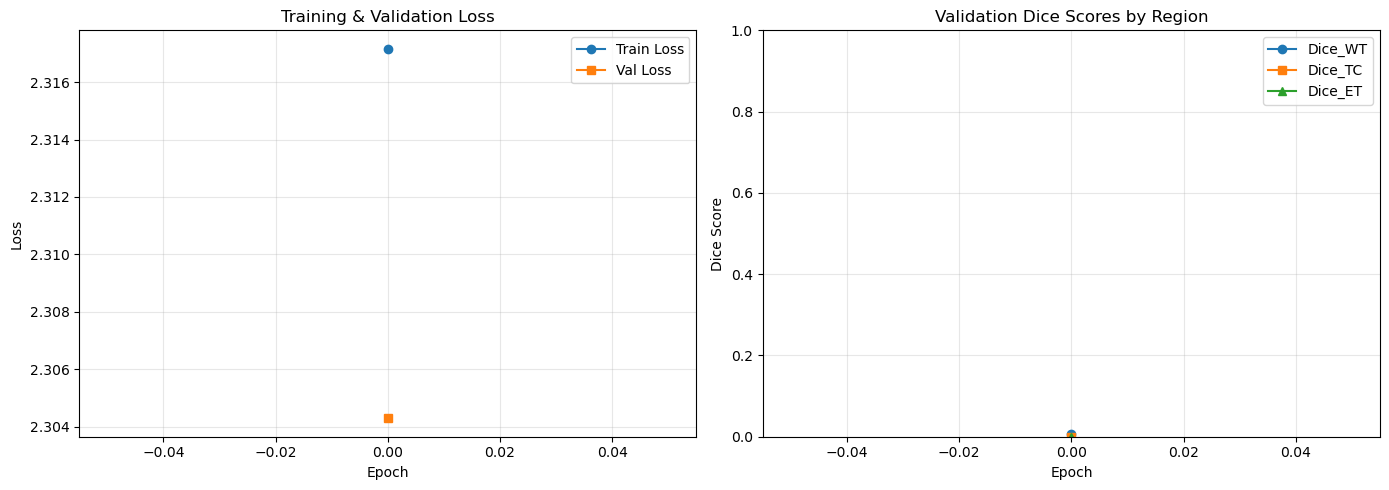

✓ Training history saved to ./output/training_history.png


In [48]:
# Plot training history

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Dice metrics
axes[1].plot(history['val_metrics']['Dice_WT'], label='Dice_WT', marker='o')
axes[1].plot(history['val_metrics']['Dice_TC'], label='Dice_TC', marker='s')
axes[1].plot(history['val_metrics']['Dice_ET'], label='Dice_ET', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Validation Dice Scores by Region')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig(Path(Config.OUTPUT_DIR) / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Training history saved to {Config.OUTPUT_DIR}/training_history.png")

---

## Section 7: Inference & Post-Processing

In [49]:
# Load best model for inference

model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()
print(f"✓ Best model loaded from {best_model_path}")

✓ Best model loaded from checkpoint\best_model.pth


In [50]:
# Inference Functions: Sliding Window Prediction

def sliding_window_inference(
    model,
    volumes,
    patch_size=(128, 128, 128),
    overlap=0.5,
    device='cuda'
):
    """
    Perform sliding window inference on a full 3D volume.
    
    Args:
        model: Trained model
        volumes: (C, H, W, D) input volume
        patch_size: Patch size for each inference step
        overlap: Overlap ratio between patches (0-1)
        device: torch device
    
    Returns:
        Predicted segmentation (H, W, D) with class indices
    """
    c, h, w, d = volumes.shape
    ph, pw, pd = patch_size
    
    # Initialize output and weight maps
    output_shape = (4, h, w, d)  # 4 classes
    output = np.zeros(output_shape, dtype=np.float32)
    weights = np.zeros((h, w, d), dtype=np.float32)
    
    # Compute stride from overlap
    stride_h = int(ph * (1 - overlap))
    stride_w = int(pw * (1 - overlap))
    stride_d = int(pd * (1 - overlap))
    
    stride_h = max(1, stride_h)
    stride_w = max(1, stride_w)
    stride_d = max(1, stride_d)
    
    # Sliding window loop
    positions = []
    for i in range(0, h - ph + 1, stride_h):
        for j in range(0, w - pw + 1, stride_w):
            for k in range(0, d - pd + 1, stride_d):
                positions.append((i, j, k))
    
    # Handle edge cases
    if h > ph:
        positions.append((h - ph, 0, 0))
    if w > pw:
        positions.append((0, w - pw, 0))
    if d > pd:
        positions.append((0, 0, d - pd))
    
    positions = list(set(positions))  # Remove duplicates
    
    with torch.no_grad():
        for idx, (i, j, k) in enumerate(tqdm(positions, desc="Sliding Window")):
            # Extract patch
            patch = volumes[:, i:i+ph, j:j+pw, k:k+pd]
            
            # Pad if necessary
            if patch.shape != (c, ph, pw, pd):
                pad_volumes = np.zeros((c, ph, pw, pd), dtype=np.float32)
                pad_volumes[
                    :,
                    :patch.shape[1],
                    :patch.shape[2],
                    :patch.shape[3]
                ] = patch
                patch = pad_volumes
            
            # Forward pass
            patch_tensor = torch.from_numpy(patch[None]).to(device).float()  # (1, C, H, W, D)
            patch_output = model(patch_tensor).cpu().numpy()[0]  # (4, H, W, D)
            
            # Accumulate
            output[:, i:i+ph, j:j+pw, k:k+pd] += patch_output
            weights[i:i+ph, j:j+pw, k:k+pd] += 1.0
    
    # Average
    weights = np.maximum(weights, 1.0)
    output = output / weights[None]
    
    # Argmax to get class indices
    prediction = np.argmax(output, axis=0).astype(np.uint8)
    
    return prediction

print("✓ Sliding window inference function loaded")

✓ Sliding window inference function loaded


In [51]:
# Post-processing: Remove Small Connected Components

def remove_small_components(segmentation, min_size=100):
    """
    Remove small connected components from segmentation.
    Helps reduce false positive detections.
    
    Args:
        segmentation: (H, W, D) segmentation array
        min_size: Minimum component size (in voxels)
    
    Returns:
        Cleaned segmentation
    """
    segmentation = segmentation.copy()
    labels = np.unique(segmentation)
    print(f"Labels: {labels}")
    
    for label in np.unique(segmentation):
        if label == 0:  # Skip background
            continue
        
        mask = (segmentation == label)
        labeled, num_features = ndimage.label(mask)
        
        print(f"Label {label}: {num_features} components")
        
        for component_id in tqdm(range(1, num_features + 1), desc=f"Label {label}", leave=False, unit="comp"):
            component_size = np.sum(labeled == component_id)
            if component_size < min_size:
                segmentation[labeled == component_id] = 0
    
    return segmentation




def predict_volume(model, subject_path, affine, device=torch.device('cuda')):
    """
    Full inference pipeline for a single subject.
    
    Args:
        model: Trained model
        subject_path: Path to subject data
        affine: Affine matrix for NIfTI
        device: torch device
    
    Returns:
        Predicted segmentation (H, W, D)
    """
    # Sliding window inference
    print("Running sliding window inference...")
    prediction = sliding_window_inference(
        model, subject_path, patch_size=Config.INFERENCE_PATCH_SIZE,
        overlap=Config.INFERENCE_OVERLAP, device=device
    )
    
    # Post-processing: Remove small components
    print("Applying post-processing...")
    prediction = remove_small_components(prediction, min_size=100)
    
    return prediction

print("✓ Post-processing functions loaded")

✓ Post-processing functions loaded


In [53]:
# Example Inference on Validation Subject

# Select a validation subject
if len(val_subjects) > 0:
    test_subject_id = val_subjects[0]
    print(f"Loading test subject: {test_subject_id}")
    
    # Load subject data
    test_data = load_subject_volumes(Config.DATA_ROOT, test_subject_id)
    test_volumes = preprocess_subject(test_data)['volumes']  # (4, H, W, D)
    test_label = test_data['label']  # (H, W, D)
    test_affine = test_data['affine']
    
    print(f"Volume shape: {test_volumes.shape}")
    print(f"Label shape: {test_label.shape}")
    
    # Run inference
    with torch.no_grad():
        test_prediction = sliding_window_inference(
            model, test_volumes, 
            patch_size=Config.INFERENCE_PATCH_SIZE,
            overlap=Config.INFERENCE_OVERLAP, 
            device=device
        )
    
    # Post-process
    test_prediction_cleaned = remove_small_components(test_prediction, min_size=50)
    
    print(f"\n✓ Inference complete. Prediction shape: {test_prediction_cleaned.shape}")
    
    # Compute metrics
    metrics = evaluate_brats_metrics(test_prediction_cleaned, test_label)
    print(f"\nMetrics on test subject {test_subject_id}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    for region in ['WT', 'TC', 'ET']:
        print(f"  {region}: Dice={metrics[f'Dice_{region}']:.4f}, HD95={metrics[f'HD95_{region}']:.2f}")
else:
    print("No validation subjects available for testing.")

Loading test subject: BraTS20_Training_002
Volume shape: (4, 240, 240, 155)
Label shape: (240, 240, 155)


Sliding Window: 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


Labels: [0 1 2 3]
Label 1: 337077 components


KeyboardInterrupt: 

---

## Section 8: Visualization of Predictions

In [ ]:
# Visualization Helper Function

def visualize_segmentation(
    volumes,
    prediction,
    ground_truth,
    slice_idx=None,
    axis=2
):
    """
    Visualize a slice with prediction and ground truth overlaid.
    
    Args:
        volumes: (C, H, W, D) MRI volumes
        prediction: (H, W, D) predicted segmentation
        ground_truth: (H, W, D) ground truth segmentation
        slice_idx: Slice index to visualize (default: middle slice)
        axis: Axis to slice along (0=axial, 1=coronal, 2=sagittal)
    """
    # Select middle slice if not specified
    if slice_idx is None:
        slice_idx = volumes.shape[axis + 1] // 2
    
    # Extract slice
    if axis == 0:  # Axial
        img_slice = volumes[0, slice_idx]  # Use T1
        pred_slice = prediction[slice_idx]
        gt_slice = ground_truth[slice_idx]
        title_suffix = f"Axial (slice {slice_idx})"
    elif axis == 1:  # Coronal
        img_slice = volumes[0, :, slice_idx]
        pred_slice = prediction[:, slice_idx]
        gt_slice = ground_truth[:, slice_idx]
        title_suffix = f"Coronal (slice {slice_idx})"
    else:  # Sagittal
        img_slice = volumes[0, :, :, slice_idx]
        pred_slice = prediction[:, :, slice_idx]
        gt_slice = ground_truth[:, :, slice_idx]
        title_suffix = f"Sagittal (slice {slice_idx})"
    
    # Color map for labels
    cmap = {
        0: [0, 0, 0],  # Background (black)
        1: [1, 0, 0],  # NCR/NET (red)
        2: [0, 1, 0],  # ED (green)
        3: [0, 0, 1],  # ET (blue)
    }
    
    def convert_to_rgb(seg):
        rgb = np.zeros((*seg.shape, 3), dtype=np.float32)
        for label, color in cmap.items():
            mask = seg == label
            for c in range(3):
                rgb[..., c][mask] = color[c]
        return rgb
    
    pred_rgb = convert_to_rgb(pred_slice)
    gt_rgb = convert_to_rgb(gt_slice)
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # MRI image
    axes[0].imshow(img_slice, cmap='gray')
    axes[0].set_title(f"T1 - {title_suffix}")
    axes[0].axis('off')
    
    # Ground truth
    axes[1].imshow(img_slice, cmap='gray')
    axes[1].imshow(gt_rgb, alpha=0.6)
    axes[1].set_title(f"Ground Truth - {title_suffix}")
    axes[1].axis('off')
    
    # Prediction
    axes[2].imshow(img_slice, cmap='gray')
    axes[2].imshow(pred_rgb, alpha=0.6)
    axes[2].set_title(f"Prediction - {title_suffix}")
    axes[2].axis('off')
    
    # Legend
    handles = [
        mpatches.Patch(color=[1, 0, 0], label='NCR/NET'),
        mpatches.Patch(color=[0, 1, 0], label='ED'),
        mpatches.Patch(color=[0, 0, 1], label='ET'),
    ]
    fig.legend(handles=handles, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.02))
    
    plt.tight_layout()
    return fig

print("✓ Visualization function loaded")

In [ ]:
# Visualize predictions

if len(val_subjects) > 0:
    # Axial view
    fig_axial = visualize_segmentation(
        test_volumes, test_prediction_cleaned, test_label, axis=0
    )
    plt.savefig(Path(Config.OUTPUT_DIR) / f'{test_subject_id}_axial.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Coronal view
    fig_cor = visualize_segmentation(
        test_volumes, test_prediction_cleaned, test_label, axis=1
    )
    plt.savefig(Path(Config.OUTPUT_DIR) / f'{test_subject_id}_coronal.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Sagittal view
    fig_sag = visualize_segmentation(
        test_volumes, test_prediction_cleaned, test_label, axis=2
    )
    plt.savefig(Path(Config.OUTPUT_DIR) / f'{test_subject_id}_sagittal.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Visualizations saved to {Config.OUTPUT_DIR}/")
else:
    print("No validation subjects available for visualization.")

---

## Section 9: Uncertainty Estimation (Monte Carlo Dropout)

In [ ]:
# Monte Carlo Dropout for Uncertainty Estimation

def monte_carlo_dropout_inference(
    model,
    volumes,
    n_passes=20,
    patch_size=(128, 128, 128),
    overlap=0.5,
    device='cuda'
):
    """
    Perform MC Dropout inference: run multiple forward passes with dropout enabled.
    Compute mean and variance of predictions to estimate uncertainty.
    
    Args:
        model: Trained model (with dropout layers)
        volumes: (C, H, W, D) input volume
        n_passes: Number of forward passes
        patch_size: Patch size
        overlap: Overlap ratio
        device: torch device
    
    Returns:
        pred_mean: Mean prediction (H, W, D, C)
        pred_std: Std of predictions (H, W, D)
    """
    c, h, w, d = volumes.shape
    
    # Store all predictions
    predictions = []
    
    print(f"Running {n_passes} MC Dropout passes...")
    for pass_idx in tqdm(range(n_passes), desc="MC Dropout"):
        model.train()  # Enable dropout
        with torch.no_grad():
            pred = sliding_window_inference(
                model, volumes, patch_size=patch_size,
                overlap=overlap, device=device
            )
        predictions.append(pred)
    
    # Stack predictions: (n_passes, H, W, D)
    predictions = np.stack(predictions, axis=0)
    
    # Compute statistics
    pred_mean = predictions.mean(axis=0)
    pred_std = predictions.std(axis=0)
    
    # Normalize uncertainty to [0, 1]
    pred_std = (pred_std - pred_std.min()) / (pred_std.max() - pred_std.min() + 1e-8)
    
    model.eval()  # Disable dropout
    
    return pred_mean, pred_std

print("✓ MC Dropout uncertainty estimation function loaded")

In [ ]:
# Run MC Dropout on test subject (skip if computationally expensive)

# To save computation time, we can skip this in DEBUG_MODE or for initial testing
# Uncomment below to run uncertainty estimation

RUN_MC_DROPOUT = not Config.DEBUG_MODE  # Skip in debug mode

if RUN_MC_DROPOUT and len(val_subjects) > 0:
    print("⏳ Computing uncertainty estimates (this may take a while)...\n")
    
    pred_mean, pred_std = monte_carlo_dropout_inference(
        model, test_volumes,
        n_passes=Config.MC_DROPOUT_PASSES,
        patch_size=Config.INFERENCE_PATCH_SIZE,
        overlap=Config.INFERENCE_OVERLAP,
        device=device
    )
    
    print("✓ Uncertainty estimation complete")
    print(f"  Mean prediction shape: {pred_mean.shape}")
    print(f"  Std map shape: {pred_std.shape}")
elif not RUN_MC_DROPOUT:
    print("⏭️ Skipping MC Dropout (DEBUG_MODE enabled)")
else:
    print("No validation subjects available for uncertainty estimation.")

In [ ]:
# Visualize uncertainty map

if RUN_MC_DROPOUT and len(val_subjects) > 0:
    # Get mean prediction from MC samples
    mc_prediction = np.argmax(pred_mean, axis=-1).astype(np.uint8)
    
    # Visualize uncertainty
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    slice_idx = test_volumes.shape[1] // 2
    
    # Axial
    img_slice = test_volumes[0, slice_idx]
    unc_slice = pred_std[slice_idx]
    
    axes[0, 0].imshow(img_slice, cmap='gray')
    axes[0, 0].set_title("MRI (Axial)")
    axes[0, 0].axis('off')
    
    im = axes[0, 1].imshow(unc_slice, cmap='hot')
    axes[0, 1].set_title("Uncertainty Map (Axial)")
    axes[0, 1].axis('off')
    plt.colorbar(im, ax=axes[0, 1], label='Std Dev')
    
    axes[0, 2].imshow(img_slice, cmap='gray')
    axes[0, 2].imshow(unc_slice, cmap='hot', alpha=0.5)
    axes[0, 2].set_title("Uncertainty Overlay (Axial)")
    axes[0, 2].axis('off')
    
    # Coronal
    slice_idx_cor = test_volumes.shape[2] // 2
    img_slice_cor = test_volumes[0, :, slice_idx_cor]
    unc_slice_cor = pred_std[:, slice_idx_cor]
    
    axes[1, 0].imshow(img_slice_cor, cmap='gray')
    axes[1, 0].set_title("MRI (Coronal)")
    axes[1, 0].axis('off')
    
    im = axes[1, 1].imshow(unc_slice_cor, cmap='hot')
    axes[1, 1].set_title("Uncertainty Map (Coronal)")
    axes[1, 1].axis('off')
    plt.colorbar(im, ax=axes[1, 1], label='Std Dev')
    
    axes[1, 2].imshow(img_slice_cor, cmap='gray')
    axes[1, 2].imshow(unc_slice_cor, cmap='hot', alpha=0.5)
    axes[1, 2].set_title("Uncertainty Overlay (Coronal)")
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(Path(Config.OUTPUT_DIR) / f'{test_subject_id}_uncertainty.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Uncertainty visualization saved to {Config.OUTPUT_DIR}/")
else:
    print("MC Dropout not run or no validation subjects available.")

---

## Section 10: Save Predictions as NIfTI

In [ ]:
# Save predictions as NIfTI files

def save_segmentation_nifti(segmentation, affine, output_path, description=""):
    """
    Save segmentation as NIfTI file.
    
    Args:
        segmentation: (H, W, D) segmentation array
        affine: (4, 4) affine transformation matrix
        output_path: Path to save NIfTI file
        description: Optional description
    """
    img = nib.Nifti1Image(segmentation, affine=affine)
    img.header.set_data_dtype(np.uint8)
    if description:
        img.header['descrip'] = description.encode('utf-8')[:80]
    nib.save(img, output_path)
    print(f"✓ Saved: {output_path}")

# Save test subject prediction
if len(val_subjects) > 0:
    output_path = Path(Config.OUTPUT_DIR) / f'{test_subject_id}_pred.nii.gz'
    save_segmentation_nifti(
        test_prediction_cleaned,
        test_affine,
        output_path,
        description="3D U-Net Segmentation Prediction"
    )

print(f"\n✓ Predictions saved to {Config.OUTPUT_DIR}/")

---

## Section 11: Cross-Validation Setup (Optional)

In [ ]:
# 5-Fold Cross-Validation Framework

def run_cross_validation(
    subject_ids,
    n_folds=5,
    epochs_per_fold=10,
    fold_idx=0  # Which fold to run (default: 0)
):
    """
    Run k-fold cross-validation.
    This is a framework function; actual execution is computationally intensive.
    
    Args:
        subject_ids: List of all subject IDs
        n_folds: Number of folds
        epochs_per_fold: Epochs per fold
        fold_idx: Which fold to run
    
    Returns:
        Cross-validation results
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)
    
    cv_results = {}
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(subject_ids)):
        if fold != fold_idx:
            continue  # Skip other folds
        
        print(f"\n{'='*70}")
        print(f"FOLD {fold + 1}/{n_folds}")
        print(f"{'='*70}")
        
        # Get train/val splits
        train_subjects_fold = [subject_ids[i] for i in train_idx]
        val_subjects_fold = [subject_ids[i] for i in val_idx]
        
        print(f"Train subjects: {len(train_subjects_fold)}")
        print(f"Val subjects: {len(val_subjects_fold)}")
        
        # [Training code would go here - similar to main training loop]
        # For now, this is just a framework demonstration
        
        cv_results[f'fold_{fold}'] = {
            'train_subjects': train_subjects_fold,
            'val_subjects': val_subjects_fold,
            'status': 'Not Run'
        }
    
    return cv_results

print("✓ Cross-validation framework loaded")
print("\nTo run full 5-fold cross-validation:")
print("  cv_results = run_cross_validation(all_subjects, n_folds=5, fold_idx=0)")
print("  (Repeat for fold_idx=1,2,3,4)")

---

## Section 12: Export & Cleanup

In [ ]:
# Save metrics to CSV

# Prepare metrics dataframe
metrics_data = []
for epoch in range(len(history['train_loss'])):
    metrics_data.append({
        'Epoch': epoch + 1,
        'Train_Loss': history['train_loss'][epoch],
        'Val_Loss': history['val_loss'][epoch],
        'Dice_WT': history['val_metrics']['Dice_WT'][epoch],
        'Dice_TC': history['val_metrics']['Dice_TC'][epoch],
        'Dice_ET': history['val_metrics']['Dice_ET'][epoch],
    })

metrics_df = pd.DataFrame(metrics_data)
metrics_path = Path(Config.OUTPUT_DIR) / 'training_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)

print(f"✓ Metrics saved to {metrics_path}")
print("\nMetrics Summary:")
print(metrics_df.tail())

In [ ]:
# Create summary report

summary_text = f"""
# BraTS-2020 3D U-Net Segmentation - Training Summary

## Configuration
- Patch Size: {Config.PATCH_SIZE}
- Batch Size: {Config.BATCH_SIZE}
- Epochs: {len(history['train_loss'])}
- Learning Rate: {Config.LEARNING_RATE}
- Device: {device}

## Dataset
- Total Subjects: {len(all_subject_folders)}
- Training: {len(train_subjects)}
- Validation: {len(val_subjects)}

## Model
- Architecture: 3D U-Net (MONAI)
- Input Channels: {Config.IN_CHANNELS} (T1, T1ce, T2, FLAIR)
- Output Classes: {Config.OUT_CHANNELS} (Background, NCR/NET, ED, ET)
- Total Parameters: {total_params:,}
- Trainable Parameters: {trainable_params:,}

## Training Results
- Best Val Loss: {min(history['val_loss']):.4f}
- Final Dice_WT: {history['val_metrics']['Dice_WT'][-1]:.4f}
- Final Dice_TC: {history['val_metrics']['Dice_TC'][-1]:.4f}
- Final Dice_ET: {history['val_metrics']['Dice_ET'][-1]:.4f}

## Files Generated
- Model Checkpoint: {best_model_path}
- Metrics CSV: {metrics_path}
- Visualizations: {Config.OUTPUT_DIR}/
- Training History Plot: {Config.OUTPUT_DIR}/training_history.png

## Notes
- Preprocessing: Z-score normalization per modality, brain mask-aware
- Loss Function: DiceCELoss (Dice + Cross Entropy)
- Optimizer: AdamW with CosineAnnealingLR
- Inference: Sliding-window with post-processing (small component removal)
"""

summary_path = Path(Config.OUTPUT_DIR) / 'SUMMARY.md'
with open(summary_path, 'w') as f:
    f.write(summary_text)

print(f"✓ Summary report saved to {summary_path}")

In [ ]:
# Create output archive

import zipfile

archive_name = 'BraTS_3DUNet_Results.zip'
archive_path = Path(archive_name)

with zipfile.ZipFile(archive_path, 'w', zipfile.ZIP_DEFLATED) as zf:
    # Add model checkpoint
    if best_model_path.exists():
        zf.write(best_model_path, arcname='model/best_model.pth')
    
    # Add all outputs
    for file in Path(Config.OUTPUT_DIR).glob('*'):
        if file.is_file():
            zf.write(file, arcname=f'outputs/{file.name}')
    
    # Add summary
    zf.write(summary_path, arcname='SUMMARY.md')

print(f"✓ Archive created: {archive_path}")
print(f"  Size: {archive_path.stat().st_size / 1e6:.1f} MB")
print(f"\nTo download results, use: files.download('{archive_path}')  # Colab")

---

## Section 13: References & Citations

### References

**BraTS Dataset:**
- Menze, B. H., et al. (2015). The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS). IEEE TMI, 34(8), 1993-2024.
  - Dataset: https://www.med.upenn.edu/cbica/brats2020/
  - Citation: arXiv:1811.02629 (BraTS 2020)

**3D U-Net Architecture:**
- Çiçek, Ö., Abdulkadir, A., Lienkamp, S. S., Brox, T., & Ronneberger, O. (2016). 3D U-Net: Learning dense volumetric segmentation from sparse annotation. MICCAI 2016.
  - Implementation: MONAI (Medical Open Network for AI)

**Loss Functions:**
- Dice Loss: Milletari, F., Navab, N., & Ahmadi, S. A. (2016). The Dice coefficient for measuring segmentation accuracy. MICCAI 2016.
- Combined Dice-CE Loss: Commonly used in medical imaging

**Metrics:**
- Hausdorff Distance: Hausdorff, F. (1914). Grundzüge der Mengenlehre.
- HD95 is standard in BraTS evaluation

**Libraries:**
- MONAI: Cardoso, M. J., et al. (2022). MONAI: Medical Open Network for AI. arXiv:2211.02701
- TorchIO: Pérez-García, F., et al. (2021). TorchIO: A Python Library for Efficient Loading, Preprocessing, Augmentation and Patch-Based Sampling of Medical Images. Computer Methods and Programs in Biomedicine. https://github.com/fepegar/torchio
- PyTorch: Paszke, A., et al. (2019). PyTorch: An imperative style, high-performance deep learning library. NeurIPS 2019.

**Uncertainty Estimation:**
- MC Dropout: Gal, Y., & Ghahramani, Z. (2016). Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning. ICML 2016.
- QU-BraTS: https://www.med.upenn.edu/cbica/qu-brats/ (Uncertainty quantification challenge)

---

## Quick Start Checklist

### Before Running This Notebook:

1. **Obtain BraTS-2020 Dataset**
   - Register at: https://www.med.upenn.edu/cbica/brats2020/
   - Download the training dataset (imagesTr + labelsTr)
   - Extract to a local folder

2. **Update Configuration**
   - In Section 1 (Config cell), update `DATA_ROOT` to point to your BraTS folder
   - Example: `DATA_ROOT = '/data/BraTS2020'`

3. **GPU Setup** (Optional but recommended)
   - Ensure CUDA 11.8+ is installed
   - Have at least 8GB VRAM (16GB+ recommended)
   - For smaller GPUs: reduce `PATCH_SIZE` to (96, 96, 96) or (64, 64, 64)

4. **Test with Debug Mode** (Recommended)
   - Set `DEBUG_MODE = True` in Config to run quickly on 2 subjects
   - Verify everything works before running full training
   - Runtime: ~5-10 minutes

5. **Full Training**
   - Set `DEBUG_MODE = False` to train on all subjects
   - Set `NUM_EPOCHS` to desired value (e.g., 50)
   - Estimated runtime: 30-60 minutes per epoch on 24GB GPU

6. **Download Results**
   - After training, Section 12 creates a zip archive
   - In Colab: `files.download('BraTS_3DUNet_Results.zip')`
   - In local notebook: file is saved in current directory

### Runtime Notes:

- **Colab Free Tier**: May timeout after 12 hours; save checkpoints frequently
- **Batch Size**: Reduce if OOM errors occur
- **Patch Size**: Reduce for smaller GPUs (128×128×128 → 96×96×96 or 64×64×64)
- **Num Workers**: Set to 0 on Windows; increase on Linux for faster loading
- **MC Dropout**: Skip during initial testing (computationally expensive)

### Expected Outputs:

```
outputs/
├── best_model.pth              # Trained model weights
├── training_metrics.csv         # Loss & Dice scores per epoch
├── training_history.png         # Loss and Dice curves
├── {subject_id}_axial.png       # Prediction visualization (axial)
├── {subject_id}_coronal.png     # Prediction visualization (coronal)
├── {subject_id}_sagittal.png    # Prediction visualization (sagittal)
├── {subject_id}_uncertainty.png # Uncertainty heatmaps (if MC Dropout run)
└── {subject_id}_pred.nii.gz     # Predicted segmentation (NIfTI format)
```

---